In [1]:
from torch import nn
import torch
import os
import numpy as np
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import matplotlib.pyplot as plt

class dianet(nn.Module): # 
    def __init__(self):
        super(dianet, self).__init__()
        self.fc1 = nn.Linear(5, 4)
        self.fc2 = nn.Linear(5, 3)
        self.fc3 = nn.Linear(3, 2)
        self.fc4 = nn.Linear(2, 1)
        self.msk1 = np.array([[1,0,0,0,0],[1,1,1,0,0],[0,0,1,1,1],[0,0,0,0,1]])
        self.msk2 = np.array([[1,1,0,0,0],[0,1,1,1,0],[0,0,0,1,1]])
        self.msk3 = np.array([[1,1,0],[0,1,1]])

    def forward(self, x, dwn=-1, up=1):
        self.fc1.weight.data *= torch.from_numpy(self.msk1).float()
        self.fc1.weight.data = torch.clamp(self.fc1.weight.data, min=dwn, max=up)
        self.fc1.bias.data = torch.clamp(self.fc1.bias.data, min=dwn, max=up)
        x1 = torch.sigmoid(self.fc1(x[:,0:5]))
        x1c = torch.cat((x1[:,0:2], x[:,5:6], x1[:,2:4]), 1) # 5

        self.fc2.weight.data *= torch.from_numpy(self.msk2).float()
        self.fc2.weight.data = torch.clamp(self.fc2.weight.data, min=dwn, max=up)
        self.fc2.bias.data = torch.clamp(self.fc2.bias.data, min=dwn, max=up)
        x2 = torch.sigmoid(self.fc2(x1c)) # 3

        self.fc3.weight.data *= torch.from_numpy(self.msk3).float()
        self.fc3.weight.data = torch.clamp(self.fc3.weight.data, min=dwn, max=up)
        self.fc3.bias.data = torch.clamp(self.fc3.bias.data, min=dwn, max=up)
        x3 = self.fc3(x2) # 2
        x3 = x3+x1[:,1:-1]

        self.fc4.weight.data = torch.clamp(self.fc4.weight.data, min=dwn, max=up)
        self.fc4.bias.data = torch.clamp(self.fc4.bias.data, min=dwn, max=up)
        x4 = self.fc4(x3) # 1

        return x4

In [2]:
def create_random_rgb_pairs(image, N):
    assert N <= image.shape[0] * image.shape[1], "N must be less than or equal to the number of pixels in the image"
    # Flatten the image array
    flat_image = image.reshape(-1, 3)

    # Randomly select N * 2 indices from the flattened array
    indices = np.random.choice(len(flat_image), size=N * 2, replace=False)

    # Extract RGB values at the selected indices
    selected_rgbs = flat_image[indices]

    # Create a new array of shape (N, 6) with random RGB pairs
    random_rgb_pairs = selected_rgbs.reshape(N, 6)

    return random_rgb_pairs

# np random seed 0
np.random.seed(0)

image1 = np.load('jpegdata/1.npy')
image1 = image1/255.0
N1 = 20000  # Number of random RGB pairs

image2 = np.load('jpegdata/2.npy')
image2 = image2/255.0
N2 = 20000  # Number of random RGB pairs

image3 = np.load('jpegdata/3.npy')
image3 = image3/255.0
N3 = 20000  # Number of random RGB pairs

rgb_pairs1 = create_random_rgb_pairs(image1, N1)
# print("Random RGB pairs:\n", rgb_pairs1.shape)
rgb_pairs2 = create_random_rgb_pairs(image2, N2)
# print("Random RGB pairs:\n", rgb_pairs2.shape)
rgb_pairs3 = create_random_rgb_pairs(image3, N3)
# print("Random RGB pairs:\n", rgb_pairs3.shape)

def dist(x):
    return (np.sqrt((x[0]-x[3])**2+(x[1]-x[4])**2+(x[2]-x[5])**2)/10.0)

dist1 = np.zeros((N1,1))
for i in range(N1):
    dist1[i] = dist(rgb_pairs1[i])
dist2 = np.zeros((N2,1))
for i in range(N2):
    dist2[i] = dist(rgb_pairs2[i])
dist3 = np.zeros((N3,1))
for i in range(N3):
    dist3[i] = dist(rgb_pairs3[i])

# concat rgb pairs and labels
rgb_pairs = np.concatenate((rgb_pairs1, rgb_pairs2, rgb_pairs3), axis=0)
print("RGB pairs:\n", rgb_pairs.shape)
dists = np.concatenate((dist1, dist2, dist3), axis=0)
print("Dists:\n", dists.shape)

# **********************************************************************************************************************

def read_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    input_data = []
    target_data = []
    
    for i, line in enumerate(lines):
        # print(i, line)
        if i % 2 == 0:  # Input data (rows 1, 3, 5, 7, ...)
            input_data.append([float(x) for x in line.strip().split()])
        else:          # Target data (rows 2, 4, 6, 8, ...)
            target_data.append([float(x) for x in line.strip().split()])

    # Convert to NumPy arrays and reshape
    input_array = np.array(input_data).reshape(-1, 6)
    target_array = np.array(target_data).reshape(-1, 1)
    
    return input_array, target_array

# train_in, train_target = read_data('k2jdata/aggregated_train.txt')
# print("input:", train_in.shape, "target:", train_target.shape)
# train_in = torch.from_numpy(train_in).float()
# train_target = torch.from_numpy(train_target).float()

# test_in, test_target = read_data('kmeans_data/aggregated_test.fann')
# print("test in:", test_in.shape, "test targ:", test_target.shape)
# test_in = torch.from_numpy(test_in).float()
# test_target = torch.from_numpy(test_target).float()

test_in = torch.from_numpy(rgb_pairs3).float()
test_target = torch.from_numpy(dist3).float()


RGB pairs:
 (60000, 6)
Dists:
 (60000, 1)


In [60]:
model = dianet() # ep 100; 0.004262
# model.load_state_dict(torch.load('kmeans_data/dianet.pth'))
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_min = 99
for epoch in range(1,1001):
    bsz = 16
    epoch_loss = 0
    count = 0
    for i in range(0, 10000, bsz):
        inputs = torch.from_numpy(rgb_pairs[i:i+bsz]).float()
        labels = torch.from_numpy(dists[i:i+bsz]).float()
        optimizer.zero_grad()
        outputs = model(inputs, dwn=-1, up=1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        count += 1
    epoch_loss /= count

    with torch.no_grad():
        test_outputs = model(test_in)
        test_loss = criterion(test_outputs, test_target)
        if test_loss<loss_min:
            loss_min = test_loss
            torch.save(model.state_dict(), 'kmeans_data/dianet-11.pth')
            print('saved at epoch', epoch, 'with loss', test_loss.item())

saved at epoch 1 with loss 0.006345502566546202
saved at epoch 2 with loss 0.0056439354084432125
saved at epoch 3 with loss 0.004790478385984898
saved at epoch 4 with loss 0.0038970280438661575
saved at epoch 5 with loss 0.003131961217150092
saved at epoch 6 with loss 0.0026363423094153404
saved at epoch 7 with loss 0.0024041521828621626
saved at epoch 8 with loss 0.0023252186365425587
saved at epoch 9 with loss 0.0022858723532408476
saved at epoch 10 with loss 0.002247047610580921
saved at epoch 11 with loss 0.002223111456260085
saved at epoch 12 with loss 0.0022174424957484007
saved at epoch 184 with loss 0.002214661333709955
saved at epoch 185 with loss 0.0022116045001894236
saved at epoch 186 with loss 0.0022085867822170258
saved at epoch 187 with loss 0.0022056149318814278
saved at epoch 188 with loss 0.002202703384682536
saved at epoch 189 with loss 0.0021998602896928787
saved at epoch 190 with loss 0.0021970688831061125
saved at epoch 191 with loss 0.0021943228784948587
saved at

In [4]:
model = dianet()
criterion = nn.MSELoss()
model.load_state_dict(torch.load('kmeans_data/dianet-11.pth'))
model.eval()
with torch.no_grad():
    pred = model(test_in)
    loss = criterion(pred, test_target)
    print('test loss:', loss.item())
    print('test_target', test_target[0:8].reshape(-1))
    print('pred', pred[0:8].reshape(-1))

test loss: 0.00210780231282115
test_target tensor([0.0058, 0.0111, 0.0165, 0.0020, 0.0080, 0.0059, 0.1059, 0.0044])
pred tensor([0.0628, 0.0635, 0.0654, 0.0610, 0.0618, 0.0658, 0.0861, 0.0605])


(512, 512, 3)
centers tensor([[0.6706, 0.4667, 0.4510],
        [0.8235, 0.8314, 0.8039]])
distances1 tensor([[-0.0052],
        [ 0.0806],
        [ 0.0870],
        ...,
        [ 0.0823],
        [ 0.0800],
        [ 0.0710]], grad_fn=<AddmmBackward0>)
distances2 tensor([[-0.0022],
        [ 0.0730],
        [ 0.0838],
        ...,
        [ 0.0977],
        [ 0.0947],
        [ 0.0849]], grad_fn=<AddmmBackward0>)
distances1 tensor([[-0.0097],
        [ 0.0772],
        [ 0.0829],
        ...,
        [ 0.0753],
        [ 0.0731],
        [ 0.0643]], grad_fn=<AddmmBackward0>)
distances2 tensor([[-0.0053],
        [ 0.0704],
        [ 0.0809],
        ...,
        [ 0.0937],
        [ 0.0906],
        [ 0.0809]], grad_fn=<AddmmBackward0>)
distances1 tensor([[-0.0104],
        [ 0.0762],
        [ 0.0819],
        ...,
        [ 0.0749],
        [ 0.0727],
        [ 0.0639]], grad_fn=<AddmmBackward0>)
distances2 tensor([[-0.0050],
        [ 0.0706],
        [ 0.0812],
        ...,
   

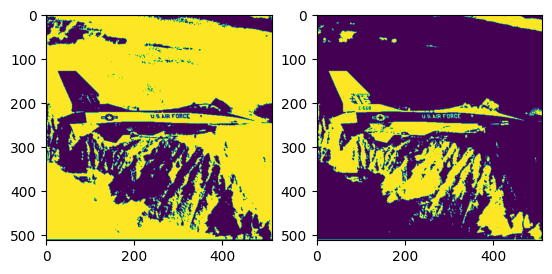

kmeansNN acc: 0.06622695922851562
error rate: 0.9663193265021063


In [12]:
import torch

def kmeans(data, k, max_iter=100):

    # Initialize cluster centers to k random data points
    np.random.seed(1)
    centers = data[torch.randperm(len(data))[:k]]

    # Convert the data and centers to tensors
    data_tc = data.float()
    centers_tc = centers.float()

    # Iterate until convergence or maximum number of iterations
    for i in range(max_iter):
        # Assign each data point to the nearest cluster center
        distances = torch.norm(data_tc[:, None, :] - centers_tc, dim=2)
        labels = torch.argmin(distances, dim=1)

        # Update cluster centers to be the mean of the data points in each cluster
        new_centers = torch.stack([torch.mean(data_tc[labels == j], dim=0) for j in range(k)])

        # Check for convergence
        if torch.allclose(centers_tc, new_centers):
            break

        centers_tc = new_centers

    # Convert the labels and centers back to numpy arrays
    labels = labels.numpy()
    centers = centers_tc.numpy()

    return labels, centers

def kmeans_NN(data, k, model, max_iter=100, debug=False):
    # Initialize cluster centers to k random data points
    np.random.seed(1)
    torch.manual_seed(0)
    centers = data[torch.randperm(len(data))[:k]]
    if debug:
        print("centers", centers)

    # Create an instance of the Net class, and load dict
    model.eval()

    # Convert the data and centers to tensors
    data_tc = data.float()
    centers_tc = centers.float()

    # Iterate until convergence or maximum number of iterations
    for i in range(max_iter):
        # Assign each data point to the nearest cluster center
        # concat the data and centers
        indata1 = torch.cat((data_tc, centers_tc[0].repeat(data_tc.shape[0], 1)), dim=1)
        indata2 = torch.cat((data_tc, centers_tc[1].repeat(data_tc.shape[0], 1)), dim=1)
        distances1 = model(indata1, dwn=-1, up=1)
        distances2 = model(indata2, dwn=-1, up=1)
        if debug:
            print("distances1", distances1)
            print("distances2", distances2)
        # distances1 = model(data_tc[:, :3], centers_tc[0, :3].repeat(data_tc.shape[0], 1))
        # distances2 = model(data_tc[:, :3], centers_tc[1, :3].repeat(data_tc.shape[0], 1))
        distances = torch.stack([distances1, distances2], dim=1).detach()
        # print(distances)
        labels = torch.argmin(distances, dim=1)
        # check if all labels are the same
        if torch.all(labels == labels[0]):
            print("All labels are the same, stopping early ---------------")
            break
        
        new_centers = []
        for j in range(k):
            # Select the data points in the j-th cluster
            data_in_cluster = data_tc[labels.squeeze() == j]
            
            if data_in_cluster.shape[0] == 0:
                # No points in this cluster, use the current cluster center as the new center
                new_centers.append(centers_tc[j])
            else:
                # Calculate the mean of the data points in the j-th cluster
                mean_of_data_in_cluster = torch.mean(data_in_cluster, dim=0)
                
                # Add the mean to the list of new centers
                new_centers.append(mean_of_data_in_cluster)

        # Stack the list of new centers into a tensor
        new_centers = torch.stack(new_centers)

        # Check for convergence
        if torch.allclose(centers_tc, new_centers):
            break

        centers_tc = new_centers

    # Convert the labels and centers back to numpy arrays
    labels = labels.numpy()
    centers = centers_tc.numpy()

    return labels, centers

# Run k-means on the data
img = np.load('jpegdata/3.npy')
print(img.shape)

img = img.reshape(-1, 3)
img = torch.from_numpy(img).float()

img = img/255.0
# model = baseline()
model = dianet()
model.load_state_dict(torch.load('kmeans_data/dianet-11.pth'))
label_NN, center_NN = kmeans_NN(img, 2, model, debug=True)
label, center = kmeans(img, 2)

# plot the labels reshape to (h, w) of kmeansNN and kmeans, using subplot
plt.subplot(1, 2, 1)
plt.imshow(label_NN.reshape(512, 512)) # dianet
plt.subplot(1, 2, 2)
plt.imshow(label.reshape(512, 512)) # real kmeans
plt.show()

# print the acc of kmeansNN and kmeans
print("kmeansNN acc:", np.sum(label_NN.reshape(512, 512) == label.reshape(512, 512))/512/512)

def image_difference_error_rate(image1, image2):
    if image1.shape != image2.shape:
        raise ValueError("The two images must have the same dimensions.")

    # Calculate the squared difference between the two images
    diff = (image1 - image2) ** 2

    # Calculate the mean squared difference
    mean_squared_diff = np.mean(diff)

    # Take the square root to get the root mean square difference
    rms_diff = np.sqrt(mean_squared_diff)

    # Normalize the RMS difference to get the error rate
    error_rate = rms_diff / max(np.max(image1), np.max(image2))

    return error_rate

# Calculate the error rate between the kmeans and kmeansNN
print("error rate:", image_difference_error_rate(label_NN.reshape(512, 512), label.reshape(512, 512)))


In [8]:
# print weights of model
# print(model.state_dict())
print(model.state_dict()['fc1.weight'])
print(model.state_dict()['fc1.bias'])
print(model.state_dict()['fc2.weight'])
print(model.state_dict()['fc2.bias'])
print(model.state_dict()['fc3.weight'])
print(model.state_dict()['fc3.bias'])
print(model.state_dict()['fc4.weight'])
print(model.state_dict()['fc4.bias'])

tensor([[ 1.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.0666, -0.9979, -0.9994,  0.0000,  0.0000],
        [-0.0000, -0.0000, -1.0000, -0.0249,  0.9999],
        [-0.0000, -0.0000, -0.0000, -0.0000, -0.9997]])
tensor([-0.1561,  0.9999, -0.9992,  0.7640])
tensor([[ 0.9999, -1.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000, -1.0000, -1.0000, -1.0000,  0.0000],
        [-0.0000, -0.0000, -0.0000,  0.9999,  1.0000]])
tensor([-0.0300, -0.5938, -0.6021])
tensor([[ 0.9993, -1.0000,  0.0000],
        [-0.0000,  1.0000,  0.9999]])
tensor([0.0269, 0.2223])
tensor([[-0.3911,  1.0000]])
tensor([-0.7652])


# clamp 0,1

In [9]:
model = dianet()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_min = 99
for epoch in range(1,1001):
    bsz = 16
    epoch_loss = 0
    count = 0
    for i in range(0, 10000, bsz):
        inputs = torch.from_numpy(rgb_pairs[i:i+bsz]).float()
        labels = torch.from_numpy(label[i:i+bsz]).float()
        optimizer.zero_grad()
        outputs = model(inputs, dwn=0, up=1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        count += 1
    epoch_loss /= count

    with torch.no_grad():
        test_outputs = model(test_in, dwn=0, up=1)
        test_loss = criterion(test_outputs, test_target)
        if test_loss<loss_min:
            loss_min = test_loss
            torch.save(model.state_dict(), 'kmeans_data/dianet01.pth')
            print('saved at epoch', epoch, 'with loss', test_loss.item())

c:\Users\comparch\anaconda3\envs\CondaPy39\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


saved at epoch 1 with loss 0.07108496874570847
saved at epoch 2 with loss 0.04615646228194237
saved at epoch 3 with loss 0.04401706904172897
saved at epoch 4 with loss 0.04377036541700363
saved at epoch 5 with loss 0.043663110584020615
saved at epoch 6 with loss 0.043599821627140045
saved at epoch 7 with loss 0.04355769604444504
saved at epoch 8 with loss 0.0435345284640789
saved at epoch 9 with loss 0.04353271797299385


KeyboardInterrupt: 

(512, 512, 3)
centers tensor([[0.6706, 0.4667, 0.4510],
        [0.8235, 0.8314, 0.8039]])
distances1 tensor([[0.2368],
        [0.2373],
        [0.2372],
        ...,
        [0.2369],
        [0.2369],
        [0.2369]], grad_fn=<AddmmBackward0>)
distances2 tensor([[0.2369],
        [0.2373],
        [0.2373],
        ...,
        [0.2369],
        [0.2369],
        [0.2370]], grad_fn=<AddmmBackward0>)
All labels are the same, stopping early ---------------


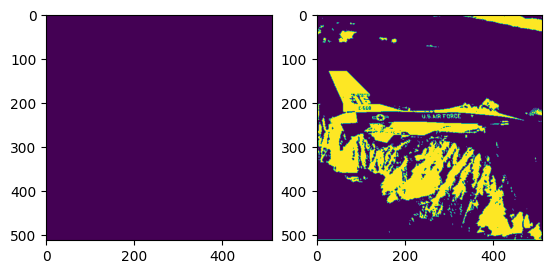

kmeansNN acc: 0.7631607055664062
error rate: 0.48666137553086514


In [11]:
import torch

def kmeans(data, k, max_iter=100):

    # Initialize cluster centers to k random data points
    np.random.seed(1)
    centers = data[torch.randperm(len(data))[:k]]

    # Convert the data and centers to tensors
    data_tc = data.float()
    centers_tc = centers.float()

    # Iterate until convergence or maximum number of iterations
    for i in range(max_iter):
        # Assign each data point to the nearest cluster center
        distances = torch.norm(data_tc[:, None, :] - centers_tc, dim=2)
        labels = torch.argmin(distances, dim=1)

        # Update cluster centers to be the mean of the data points in each cluster
        new_centers = torch.stack([torch.mean(data_tc[labels == j], dim=0) for j in range(k)])

        # Check for convergence
        if torch.allclose(centers_tc, new_centers):
            break

        centers_tc = new_centers

    # Convert the labels and centers back to numpy arrays
    labels = labels.numpy()
    centers = centers_tc.numpy()

    return labels, centers

def kmeans_NN(data, k, model, max_iter=100, debug=False):
    # Initialize cluster centers to k random data points
    np.random.seed(1)
    torch.manual_seed(0)
    centers = data[torch.randperm(len(data))[:k]]
    if debug:
        print("centers", centers)

    # Create an instance of the Net class, and load dict
    model.eval()

    # Convert the data and centers to tensors
    data_tc = data.float()
    centers_tc = centers.float()

    # Iterate until convergence or maximum number of iterations
    for i in range(max_iter):
        # Assign each data point to the nearest cluster center
        # concat the data and centers
        indata1 = torch.cat((data_tc, centers_tc[0].repeat(data_tc.shape[0], 1)), dim=1)
        indata2 = torch.cat((data_tc, centers_tc[1].repeat(data_tc.shape[0], 1)), dim=1)
        distances1 = model(indata1, dwn=0, up=1)
        distances2 = model(indata2, dwn=0, up=1)
        if debug:
            print("distances1", distances1)
            print("distances2", distances2)
        # distances1 = model(data_tc[:, :3], centers_tc[0, :3].repeat(data_tc.shape[0], 1))
        # distances2 = model(data_tc[:, :3], centers_tc[1, :3].repeat(data_tc.shape[0], 1))
        distances = torch.stack([distances1, distances2], dim=1).detach()
        # print(distances)
        labels = torch.argmin(distances, dim=1)
        # check if all labels are the same
        if torch.all(labels == labels[0]):
            print("All labels are the same, stopping early ---------------")
            break
        
        new_centers = []
        for j in range(k):
            # Select the data points in the j-th cluster
            data_in_cluster = data_tc[labels.squeeze() == j]
            
            if data_in_cluster.shape[0] == 0:
                # No points in this cluster, use the current cluster center as the new center
                new_centers.append(centers_tc[j])
            else:
                # Calculate the mean of the data points in the j-th cluster
                mean_of_data_in_cluster = torch.mean(data_in_cluster, dim=0)
                
                # Add the mean to the list of new centers
                new_centers.append(mean_of_data_in_cluster)

        # Stack the list of new centers into a tensor
        new_centers = torch.stack(new_centers)

        # Check for convergence
        if torch.allclose(centers_tc, new_centers):
            break

        centers_tc = new_centers

    # Convert the labels and centers back to numpy arrays
    labels = labels.numpy()
    centers = centers_tc.numpy()

    return labels, centers

# Run k-means on the data
img = np.load('jpegdata/3.npy')
print(img.shape)

img = img.reshape(-1, 3)
img = torch.from_numpy(img).float()

img = img/255.0
# model = baseline()
model = dianet()
model.load_state_dict(torch.load('kmeans_data/dianet01.pth'))
label_NN, center_NN = kmeans_NN(img, 2, model, debug=True)
label, center = kmeans(img, 2)

# plot the labels reshape to (h, w) of kmeansNN and kmeans, using subplot
plt.subplot(1, 2, 1)
plt.imshow(label_NN.reshape(512, 512)) # dianet
plt.subplot(1, 2, 2)
plt.imshow(label.reshape(512, 512)) # real kmeans
plt.show()

# print the acc of kmeansNN and kmeans
print("kmeansNN acc:", np.sum(label_NN.reshape(512, 512) == label.reshape(512, 512))/512/512)

def image_difference_error_rate(image1, image2):
    if image1.shape != image2.shape:
        raise ValueError("The two images must have the same dimensions.")

    # Calculate the squared difference between the two images
    diff = (image1 - image2) ** 2

    # Calculate the mean squared difference
    mean_squared_diff = np.mean(diff)

    # Take the square root to get the root mean square difference
    rms_diff = np.sqrt(mean_squared_diff)

    # Normalize the RMS difference to get the error rate
    error_rate = rms_diff / max(np.max(image1), np.max(image2))

    return error_rate

# Calculate the error rate between the kmeans and kmeansNN
print("error rate:", image_difference_error_rate(label_NN.reshape(512, 512), label.reshape(512, 512)))
